Let $C_n$ be the set of points $x = (x_1, x_2)$ which satisfy $x \in C$ and $x_1 + x_2 = n$. When $p < p_c$, it may be shown that there is a constant $\gamma > 0$ (depending on $p$) for which $P_p(C_n \neq \emptyset) \leq \exp (-\gamma n)$ and
\begin{equation}
    \frac{1}{n}\log P_p(C_n \neq \emptyset) \to -\gamma \quad \text{as} \quad n \to \infty.
\end{equation}

p=0.3: Estimated gamma = 0.55011 (using n range 1-9)
p=0.4: Estimated gamma = 0.28831 (using n range 11-18)
p=0.5: Estimated gamma = 0.11944 (using n range 11-40)
p=0.6: Estimated gamma = 0.01536 (using n range 11-304)


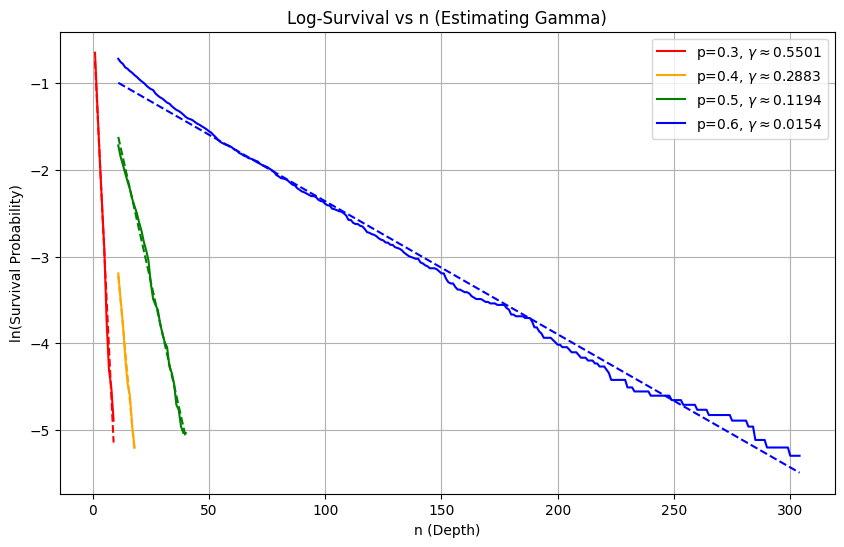

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def estimate_gamma_subcritical():
    N_MAX = 1000
    M = 2000

    # Z stores min-p values.
    Z = np.zeros((M, 1))

    # To store survival counts we use a dictionary for the list of counts per step
    target_ps = [0.3, 0.4, 0.5, 0.6]
    survival_counts = {p: [] for p in target_ps}

    # Survival at every step
    for step in range(N_MAX):
        current_width = step + 1
        next_width = step + 2

        Z_next = np.full((M, next_width), 1.1) # Initialize with > 1

        R_down = np.random.rand(M, current_width)
        R_right = np.random.rand(M, current_width)

        cost_down = np.maximum(Z, R_down)
        cost_right = np.maximum(Z, R_right)

        Z_next[:, 0:current_width] = np.minimum(Z_next[:, 0:current_width], cost_down)
        Z_next[:, 1:next_width] = np.minimum(Z_next[:, 1:next_width], cost_right)

        Z = Z_next
        min_thresholds = np.min(Z, axis=1)

        for p in target_ps:
            count = np.sum(min_thresholds <= p)
            survival_counts[p].append(count)

    return survival_counts, M

def analyse_results(survival_counts, M):
    plt.figure(figsize=(8, 5))

    gamma_estimates = {}

    colors = ['red', 'orange', 'green', 'blue']

    for i, p in enumerate(survival_counts.keys()):
        counts = np.array(survival_counts[p])
        n_values = np.arange(1, len(counts) + 1)
        probs = counts / M

        # Filter data:
        # We need probs > 0 to take log.
        # We should cut off the very beginning (transient behavior)
        # We stop when counts get too low (noise dominates) e.g., < 10 survivors
        valid_indices = np.where(counts >= 10)[0]

        if len(valid_indices) < 5:
            print(f"p={p}: Not enough data to estimate gamma.")
            continue

        # Determine range for regression
        # For low p, valid range is short. For high p, valid range is long.
        start_idx = 10 # Skip first 10 steps (transient)
        end_idx = valid_indices[-1]

        if start_idx >= end_idx:
            start_idx = 0 # Fallback for very short survival

        x_reg = n_values[start_idx:end_idx]
        y_reg = np.log(probs[start_idx:end_idx])

        # Linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x_reg, y_reg)
        gamma = -slope
        gamma_estimates[p] = gamma

        plt.plot(x_reg, y_reg, label=f'p={p}, $\\gamma \\approx {gamma:.4f}$', color=colors[i])
        plt.plot(x_reg, intercept + slope*x_reg, '--', color=colors[i])

        print(f"p={p}: Estimated gamma = {gamma:.5f} (using n range {x_reg[0]}-{x_reg[-1]})")

    plt.xlabel('n (Depth)')
    plt.ylabel('ln(Survival Probability)')
    plt.title('Log-Survival vs n (Estimating Gamma)')
    plt.legend()
    plt.grid(True)
    plt.show()

counts, Total_M = estimate_gamma_subcritical()
analyse_results(counts, Total_M)

To estimate the decay constant $\gamma$, we need to analyse how the survival probability drops as $n$ increases. The choice of $n$ and $m$ depends on the decay rate. The goal is to capture the linear region of the log-plot before the data becomes noisy but after the transient behaviour.

For a low $p$, we get fast behaviour where the survival probability drops very quickly. The simulation likely hits $0$ survivors after a very small $n$. Because survival is so rare, we need a very high $m$ to obtain reliable data.  For a high $p$ close to the critical point, the decay is very slow. Here, we need a large $n$ to accurately distinguish the exponential decay from the initial transient behavior. Since many paths survive for a long time, a lower choice of $m$ suffices.

As $p$ increases towards the critical probability $p_c$, the slope of the line in the log-plot becomes flatter and $\gamma(p)$ decreases towards 0. Here, $\gamma$ represents the inverse correlation length. It represents how quickly the system forgets the source.
*   At low $p$, the water is blocked almost immediately. The characteristic size of a wet cluster is very small.
*   As $p \to p_c$, the clusters become larger and larger. The probability of stopping decreases.
*   At $p = p_c$, the decay is no longer exponential and it becomes polynomial, which corresponds to $\gamma = 0$. The correlation length diverges to infinity.